In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Explore data base and get a list of column names and types
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
#query for the earliest date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [14]:
#query for the latest date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

# Exploratory Climate Analysis

In [15]:
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [16]:
one_year_all= session.query(Measurement.date, Measurement.prcp, Measurement.station, Measurement.tobs).\
    filter(Measurement.date >= query_date).\
    order_by(Measurement.date).all()
one_year_all_df= pd.DataFrame(one_year_all, columns=['date', 'precipitation', 'station','tobs' ])
export_csv = one_year_all_df.to_csv (r'one_year_all_df.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path
one_year_all_df

,date,precipitation,station,tobs
0,2016-08-23,0.00,USC00519397,81.0
1,2016-08-23,0.15,USC00513117,76.0
2,2016-08-23,0.05,USC00514830,80.0
3,2016-08-23,NaN,USC00517948,80.0
4,2016-08-23,0.02,USC00519523,80.0
...,...,...,...,...
2225,2017-08-22,0.50,USC00516128,76.0
2226,2017-08-23,0.00,USC00519397,81.0
2227,2017-08-23,0.00,USC00514830,82.0
2228,2017-08-23,0.08,USC00519523,82.0


In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Perform a query to retrieve the data and precipitation scores. 
#Sort the dataframe by date.
#Save the query results as a Pandas DataFrame and set the index to the date column

one_year_df= pd.DataFrame(one_year_all_df, columns=['date', 'precipitation'])
one_year_df.set_index(one_year_df['date'], inplace=True)
export_csv = one_year_df.to_csv (r'one_year_df.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path
one_year_df

,date,precipitation
date,,
2016-08-23,2016-08-23,0.00
2016-08-23,2016-08-23,0.15
2016-08-23,2016-08-23,0.05
2016-08-23,2016-08-23,NaN
2016-08-23,2016-08-23,0.02
...,...,...
2017-08-22,2017-08-22,0.50
2017-08-23,2017-08-23,0.00
2017-08-23,2017-08-23,0.00


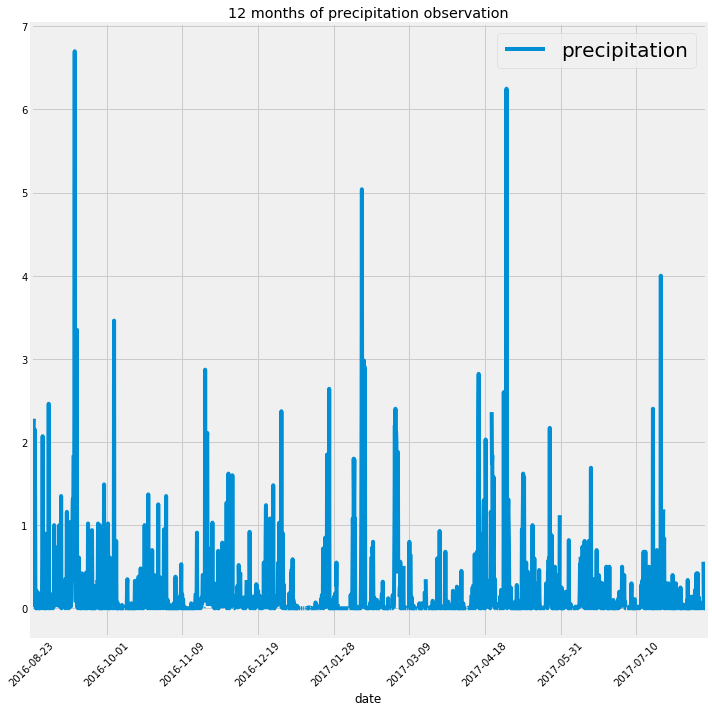

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
one_year_df = one_year_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
one_year_df.plot(rot=45, figsize = (10,10), title="12 months of precipitation observation")
plt.legend(prop={'size': 20})
plt.tight_layout()
plt.savefig("Images/12month_temp_bar.png")
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
one_year_df.describe()
sum_stat= pd.DataFrame(one_year_df.describe())
export_csv =sum_stat.to_csv (r'sum_stat.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path
sum_stat

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
unique_station= session.query(Measurement.station).distinct().count()
unique_station

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity=session.query(Measurement.station, func.count( Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count( Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_temp= session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg( Measurement.tobs)).\
 filter(Measurement.station == 'USC00519281').all()
station_temp

[(54.0, 85.0, 71.66378066378067)]

In [23]:
# Choose the station with the highest number of temperature observations.
tobs_activity=session.query(Measurement.station, func.count( Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count( Measurement.tobs).desc()).all()
tobs_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

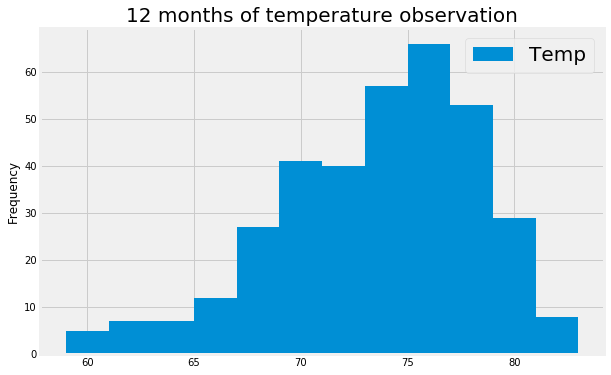

In [24]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_temp= session.query(Measurement.tobs).\
    filter(Measurement.date >= query_date).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date).all()
one_year_temp
one_year_temp_df= pd.DataFrame(one_year_temp).rename(columns={'tobs': 'Temp'})
ingris=one_year_temp_df.plot.hist(bins=12, figsize = (9,6), title="12 months of temperature observation")
ingris.title.set_size(20)
plt.legend(prop={'size': 20})
plt.savefig("Images/station_histogram.png")

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-02-01', '2017-02-16'))

[(59.0, 69.80952380952381, 80.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-02-01', '2016-02-16'))


[(56.0, 69.57281553398059, 79.0)]


In [27]:
prev_vac_start = dt.date(2016, 2, 1) - dt.timedelta(days=365)
prev_vac_end = dt.date(2016, 2, 16) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_vac_start.strftime("%Y-%m-%d"), 
                              prev_vac_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

56.0 69.50943396226415 79.0


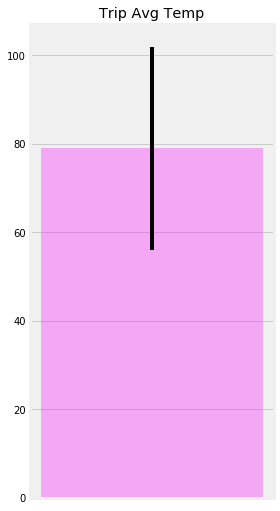

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(1.8))
xpos = 1
yerr = tmax-tmin
bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.3, 
             color='magenta', align='center')
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp")
plt.tight_layout()
plt.savefig("Images/AvgTemp_ErrorBar.png")
plt.show()

In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_vac_date = '2016-02-01'
end_vac_date = '2016-02-16'

sel = [Station.station, Station.name, Station.latitude,
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

rainfall=session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >=start_vac_date).\
    filter(Measurement.date >=end_vac_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).\
                                    desc()).all()    

rainfall_df= pd.DataFrame(rainfall, columns=['station_code', 'name', 
                                             'latitude','longitude', 
                                            'elevation', 'sum_prcp'])
rainfall_df

,station_code,name,latitude,longitude,elevation,sum_prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,226.58
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,120.16
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,84.61
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,56.91
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,46.94
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,26.25
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,6.36


## Optional Challenge Assignment

In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [32]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [33]:
# Plot the daily normals as an area plot with `stacked=False`
